# Reassortment Paths

Here, we will do a traceback from every human isolate that is the first isolate inits subgraph until we hit a non-human source.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools as itl

%matplotlib inline

In [2]:
G = nx.read_gpickle('20141103 All IRD Final Graph.pkl')

In [3]:
# Code to encode nodes according to reassortant status type
for sc, sk, d in G.edges(data=True):
    if d['edge_type'] == 'reassortant':
        G.node[sk]['node_type'] = 'reassortant'
    if d['edge_type'] == 'full_complement':
        G.node[sk]['node_type'] = 'full_complement'

for n, d in G.nodes(data=True):
    if 'node_type' not in d.keys():
        G.node[n]['node_type'] = 'source'

In [4]:
nodes_of_interest = set()
for sc, sk, d in G.edges(data=True):
    if d['edge_type'] == 'reassortant' and 'Human' in G.node[sk]['host_species']:
        nodes_of_interest.add(sk)
        
len(nodes_of_interest)

33

In [5]:
def get_hosts_species(list_of_nodes_with_data):
    host_species = set()
    for n, d in list_of_nodes_with_data:
        host_species.add(d['host_species'])
        
    return host_species


def hosts_has_non_human(set_of_host_species):
    has_non_human = False
    for host_species in set_of_host_species:
        if 'Avian' in host_species or 'avian' in host_species:
            has_non_human = True
            break
        if 'Swine' in host_species or 'swine' in host_species:
            has_non_human = True
            break
        if 'Environment' in host_species or 'environment' in host_species:
            has_non_human = True
            break
        
    return has_non_human

In [6]:
list(nodes_of_interest)[0]

'A/Canada-NS/RV1536/2009'

In [7]:
human_reassortant_subtypes = set()
for node in nodes_of_interest:
    human_reassortant_subtypes.add(G.node[node]['subtype'])
    # print(node, G.node[node])
    # print(G.predecessors(node))
    # print(set([d['pwi'] for _,_,d in G.in_edges(node, data=True)]))

In [8]:
human_reassortant_subtypes

{'H10N8', 'H1N1', 'H2N2', 'H4N8', 'H5N1', 'H7N3', 'H7N9', 'Mixed'}

In [9]:
def node_shapes_by_host(G):
    'shapes allowed: so^>v<dph8'
    shapes = []
    for n, d in G.nodes(data=True):
        host = d['host_species']
        if 'Human' in host:
            shapes.append((n, host, 'o'))
        elif 'Avian' in host:
            shapes.append((n, host, '^'))
        elif 'Unknown' in host:
            shapes.append((n, host, 'v'))
        elif 'null' in host:
            shapes.append((n, host, '>'))
        elif 'Swine' in host:
            shapes.append((n, host, 'd'))
        else:
            shapes.append((n, host, 'p'))
    return shapes

191


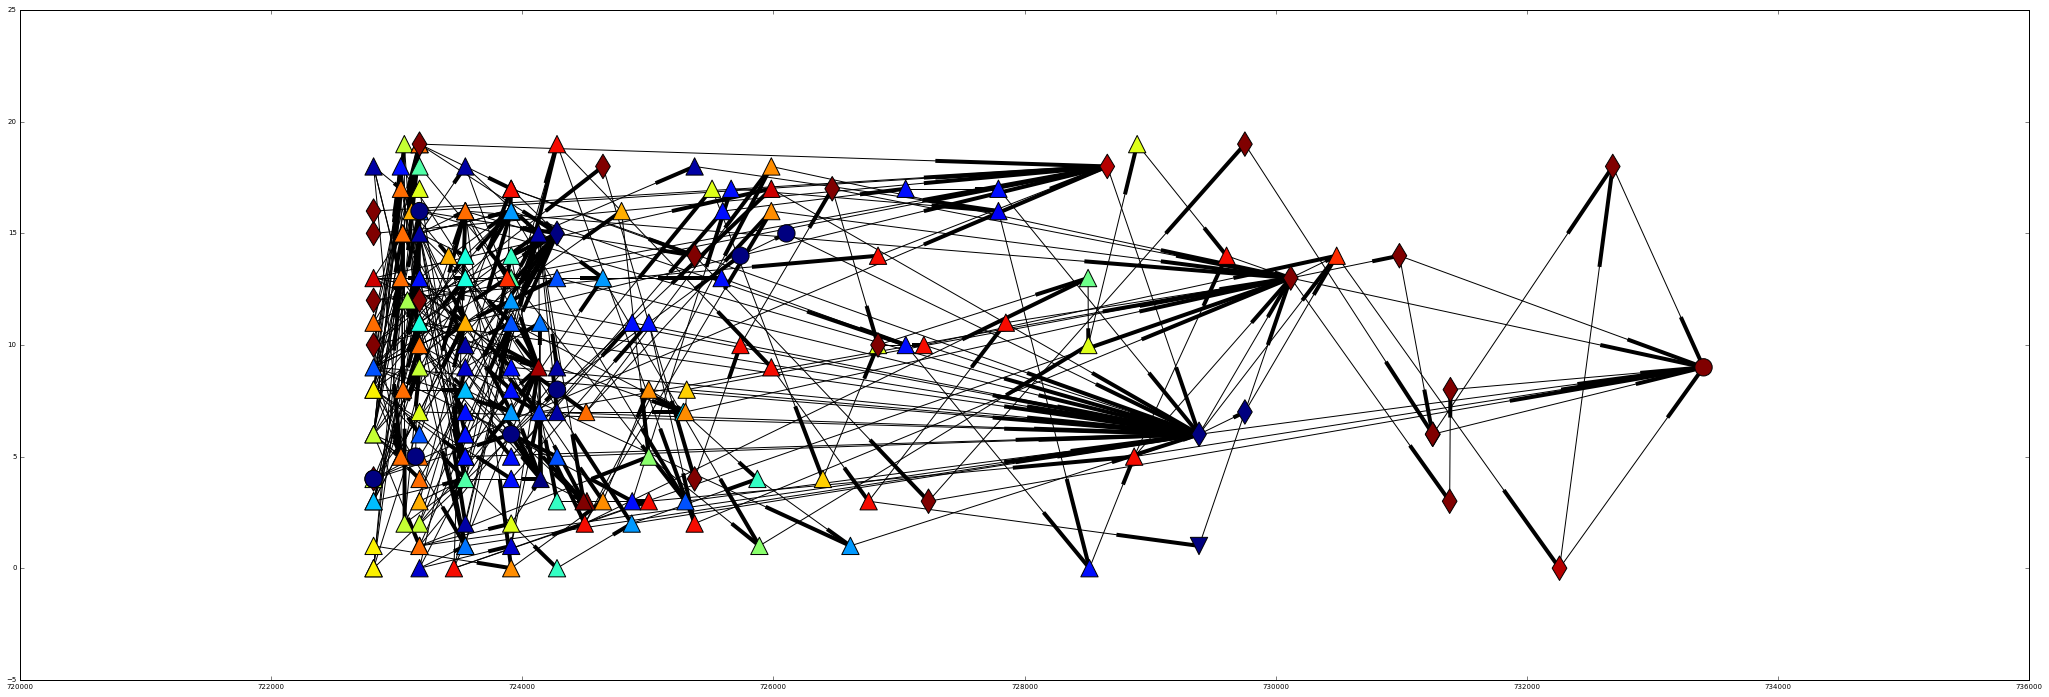

In [10]:
def search_predecessors(G, node):
    to_visit = []
    
    to_visit.extend(G.predecessors(node))
    isolates_of_interest = []
    isolates_of_interest.append(node)
    for isolate in to_visit:
        
        isolates_of_interest.append(isolate)
        if len(G.in_edges(isolate)) == 0:
            pass
        else:
            to_visit.extend(G.predecessors(isolate))
        
    return isolates_of_interest
            
nodes = search_predecessors(G, 'A/Canada-NS/RV1536/2009')  
nodes

g = G.subgraph(nodes)

# Color nodes by subtype
all_subtypes = [d['subtype'] for n, d in g.nodes(data=True)] # get subtypes
unique_subtypes = set(all_subtypes)
values = np.arange(0,1,float(1)/len(unique_subtypes)) # convert each unique subtype into a unique value from 0 to 1
valmap = dict(zip(unique_subtypes, values)) # make a dictionary of unique subtypes to the unique values between 0 and 1
xpos = {n:(d['collection_date'].toordinal(), int(np.random.random()*20)) for n, d in g.nodes(data=True)}

shapes = node_shapes_by_host(g)
shapes = sorted(shapes, key=lambda x:x[2])

fig = plt.figure(figsize=(36,12))
for shape, group in itl.groupby(shapes, key=lambda x:x[2]):
    ns = [i[0] for i in group] # get the nodes out. They are the 1st item in the tuple.
    colors = [valmap[g.node[i]['subtype']] for i in ns]
    nx.draw_networkx_nodes(g, pos=xpos, nodelist=ns, node_shape=shape, cmap=plt.get_cmap('jet'), node_color=colors)
    
nx.draw_networkx_edges(g, pos=xpos)

print(len(g.nodes()))

Algorithm to prune off stretches of a branch that doesn't involve reassortment:

1. Start at node without in_edge.
2. Trace forward until out_edge is a reassortant edge.
3. Remove current node from trace.
4. Remove remaining nodes.

In [11]:
nodes_without_in_edges = []
for n,d in g.nodes(data=True):
    if len(g.in_edges(n)) == 0:
        nodes_without_in_edges.append(n)
        
# nodes_without_in_edges

In [12]:
for node in nodes_without_in_edges:
    trace = []
    trace.extend(g.successors(node))
    nodes_to_remove = []
    for n in trace:
        out_edges = g.out_edges(n, data=True)
        out_edge_type = set([d['edge_type'] for sc, sk, d in out_edges])
        if 'reassortant' not in out_edge_type:
            print(out_edge_type)
            trace.extend(g.successors(n))
            nodes_to_remove.extend(g.successors(n))
        else:
            pass
    g.remove_nodes_from(nodes_to_remove)

set(['full_complement'])
set(['full_complement'])
set(['full_complement'])
set([])
set(['full_complement'])
set(['full_complement'])
set([])
set(['full_complement'])
set(['full_complement'])
set(['full_complement'])
set(['full_complement'])
set([])
set([])
set([])
set([])
set(['full_complement'])
set(['full_complement'])
set(['full_complement'])
set(['full_complement'])


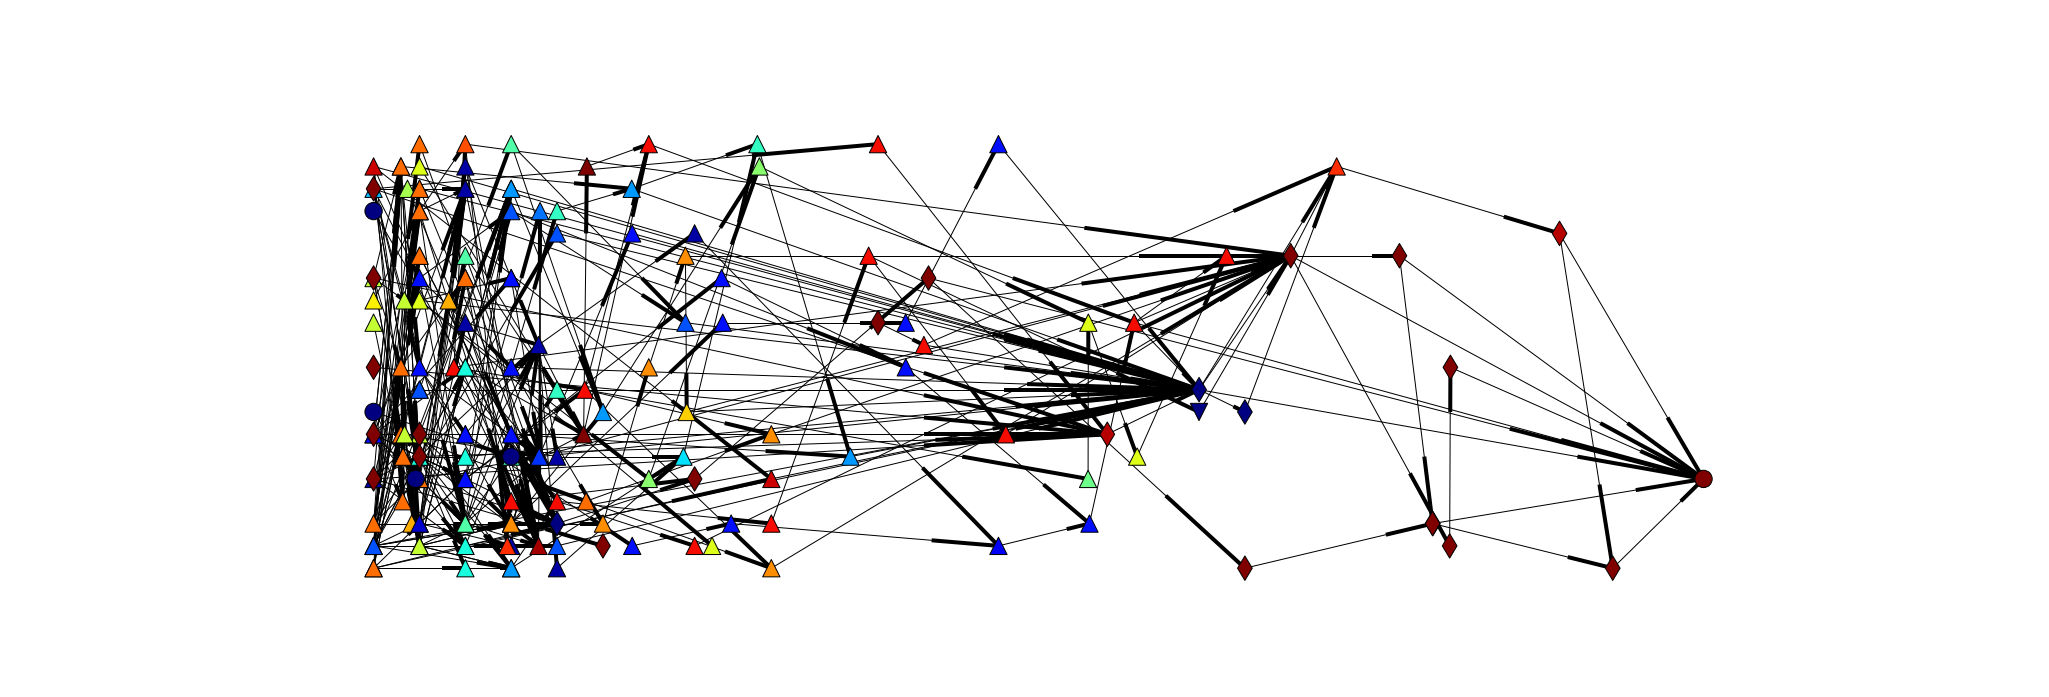

In [13]:
#### PLOT THE VERSION WITHOUT UNNECESSARY FULL COMPLEMENT EDGES #####
# Order the nodes by time on the x-axis
xpos = {n:(d['collection_date'].toordinal(), int(np.random.random()*20)) for n, d in g.nodes(data=True)}

# Color nodes by subtype
all_subtypes = [d['subtype'] for n, d in g.nodes(data=True)] # get subtypes
unique_subtypes = set(all_subtypes)
values = np.arange(0,1,float(1)/len(unique_subtypes))
valmap = dict(zip(unique_subtypes, values))
colors = [valmap[i] for i in all_subtypes]

shapes = node_shapes_by_host(g)
shapes = sorted(shapes, key=lambda x:x[2])

fig = plt.figure(figsize=(36,12))
for shape, group in itl.groupby(shapes, key=lambda x:x[2]):
    ns = [i[0] for i in group] # get the nodes out. They are the 1st item in the tuple.
    colors = [valmap[g.node[i]['subtype']] for i in ns]
    nx.draw_networkx_nodes(g, pos=xpos, nodelist=ns, node_shape=shape, cmap=plt.get_cmap('jet'), node_color=colors)
    
nx.draw_networkx_edges(g, pos=xpos)
plt.axis('off')
plt.savefig('Example Reassortant Traceback.pdf', bbox_inches='tight')

In [14]:
[d['host_species'] for n, d in g.nodes(data=True)]

['Turkey/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Blue-Winged Teal/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Duck/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Duck/Avian',
 'Avian',
 'Mallard/Avian',
 'Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Swine',
 'Mallard/Avian',
 'Mallard/Avian',
 'Swine',
 'Mallard/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Black Duck/Avian',
 'Mallard/Avian',
 'Blue-Winged Teal/Avian',
 'Pintail/Avian',
 'Green-Winged Teal/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Swine',
 'Mallard/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Swine',
 'Swine',
 'Human',
 'Swine',
 'Pigeon/Avian',
 'Duck/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Mallard/Avian',
 'Human',
 'Mallard/Avian',
 'Mallard/Avian',
 'Blue

Idea: Mixing pool is the wild bird population, and involves a cacaphony of subtypes before it comes into humans. We have no idea how many subtypes are involved.

In [15]:
set([d['subtype'] for n, d in g.nodes(data=True)])

{'H10N1',
 'H10N6',
 'H10N7',
 'H11N3',
 'H11N9',
 'H12N5',
 'H1N1',
 'H1N2',
 'H1N3',
 'H2N1',
 'H2N3',
 'H3N1',
 'H3N2',
 'H3N5',
 'H3N6',
 'H3N8',
 'H3N9',
 'H4N2',
 'H4N6',
 'H4N8',
 'H4N9',
 'H5N2',
 'H6N1',
 'H6N5',
 'H6N6',
 'H7N3',
 'H7N7',
 'H9N1',
 'H9N2',
 'Mixed'}

In [16]:
G.predecessors('A/pintail/Alberta/140/1996')
G.in_edges('A/pintail/Alberta/140/1996', data=True)

[('A/turkey/SD/7034/1986',
  'A/pintail/Alberta/140/1996',
  {'edge_type': 'reassortant',
   'pwi': 7.7673990000000002,
   'segments': {1: 0.94986999999999999,
    4: 0.96685699999999997,
    6: 0.93924600000000003,
    8: 0.98477800000000004}}),
 ('A/lesser scaup/Alberta/206/1995',
  'A/pintail/Alberta/140/1996',
  {'edge_type': 'reassortant',
   'pwi': 7.7673990000000002,
   'segments': {2: 0.98350000000000004,
    3: 0.99592400000000003,
    5: 0.96818199999999999,
    7: 0.97904199999999997}})]

In [17]:
G.predecessors('A/lesser scaup/Alberta/206/1995')
G.in_edges('A/lesser scaup/Alberta/206/1995', data=True)

[('A/pintail/Alberta/105/1991',
  'A/lesser scaup/Alberta/206/1995',
  {'edge_type': 'reassortant',
   'pwi': 7.7901740000000004,
   'segments': {1: 0.98056999999999994,
    6: 0.98675999999999997,
    7: 0.97688399999999997,
    8: 0.96878600000000004}}),
 ('A/mallard/Alberta/54/1993',
  'A/lesser scaup/Alberta/206/1995',
  {'edge_type': 'reassortant',
   'pwi': 7.7901740000000004,
   'segments': {2: 0.98272899999999996,
    3: 0.93251799999999996,
    4: 0.97816100000000006,
    5: 0.98376600000000003}})]

In [18]:
G.in_edges('A/mallard/Alberta/54/1993', data=True)

[('A/mallard/Ohio/399/1987',
  'A/mallard/Alberta/54/1993',
  {'edge_type': 'reassortant',
   'pwi': 7.8026790000000004,
   'segments': {2: 0.96538299999999999,
    3: 0.97816199999999998,
    6: 0.98170299999999999,
    7: 0.98080800000000001,
    8: 0.982456}}),
 ('A/pintail/Ohio/339/1987',
  'A/mallard/Alberta/54/1993',
  {'edge_type': 'reassortant',
   'pwi': 7.8026790000000004,
   'segments': {1: 0.98482899999999995,
    4: 0.97969799999999996,
    5: 0.94964000000000004}})]

In [19]:
G.in_edges('A/pintail/Ohio/339/1987', data=True)

[('A/blue-winged teal/ALB/569/1985',
  'A/pintail/Ohio/339/1987',
  {'edge_type': 'full_complement',
   'pwi': 7.7612759999999996,
   'segments': {1: 0.96748999999999996,
    2: 0.96614599999999995,
    3: 0.952511,
    4: 0.99478,
    5: 0.95618099999999995,
    6: 0.96265000000000001,
    7: 0.991927,
    8: 0.96959099999999998}})]

In [20]:
G.in_edges('A/blue-winged teal/ALB/569/1985', data=True)

[('A/blue-winged teal/Saskatchewan/75/1982',
  'A/blue-winged teal/ALB/569/1985',
  {'edge_type': 'full_complement',
   'pwi': 7.7952750000000002,
   'segments': {1: 0.97625200000000001,
    2: 0.96718499999999996,
    3: 0.95516299999999998,
    4: 0.98218399999999995,
    5: 0.972078,
    6: 0.97073200000000004,
    7: 0.98902199999999996,
    8: 0.98265899999999995}})]

In [21]:
G.in_edges('A/blue-winged teal/Saskatchewan/75/1982', data=True)

[('A/mallard/Wisconsin/487/1981',
  'A/blue-winged teal/Saskatchewan/75/1982',
  {'edge_type': 'full_complement',
   'pwi': 7.7602759999999993,
   'segments': {1: 0.95898099999999997,
    2: 0.97970599999999997,
    3: 0.97889899999999996,
    4: 0.97126400000000002,
    5: 0.95064899999999997,
    6: 0.96864099999999997,
    7: 0.98103799999999997,
    8: 0.97109800000000002}})]

In [22]:
G.in_edges('A/mallard/Wisconsin/487/1981', data=True)

[('A/mallard/Wisconsin/120/1980',
  'A/mallard/Wisconsin/487/1981',
  {'edge_type': 'reassortant',
   'pwi': 7.8042110000000005,
   'segments': {3: 0.98205200000000004, 6: 0.98188200000000003}}),
 ('A/pintail duck/ALB/169/1980',
  'A/mallard/Wisconsin/487/1981',
  {'edge_type': 'reassortant',
   'pwi': 7.8042110000000005,
   'segments': {1: 0.96718499999999996,
    2: 0.98618300000000003,
    4: 0.97528700000000002,
    5: 0.95454499999999998,
    7: 0.97904199999999997,
    8: 0.97803499999999999}})]